In [1]:
## import modules
import pandas as pd
import numpy as np
import seaborn as sns
import palettable
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace import sarimax
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from itertools import product 
import warnings
warnings.filterwarnings("ignore")

# Ⅰ Baseline : ARIMA Model / SARIMA Model

In [3]:
init_data = pd.read_csv("../data/Analyze_data.csv")
init_data["date"] = init_data["date"].apply(lambda x: pd.to_datetime(x))
data = init_data.dropna().reset_index(drop=True)
data

,date,log_national_home_price_index,delta_national_home_price_index,capacity_util,real_interest_rate,fed_fund_rate,stickyCPI,housing_started,housing_completed,personal_saving_rate,...,log_avg_house_prices,employ_rate_nonagri,delta_real_interest_rate,delta_housing_started,delta_housing_completed,delta_logCPI,delta_logPCE,delta_employ_rate_nonagri,delta_mortgage,delta_avg_house_prices
0,1987-02-01,4.160990,0.006256,79.8385,3.578581,6.10,0.320330,1784.0,1771.0,8.2,...,11.463735,0.971166,-0.025984,10.0,-91.0,0.003584,0.022301,-0.000507,-0.1215,-0.034077
1,1987-03-01,4.166200,0.005210,79.8055,3.554785,6.13,0.331130,1726.0,1694.0,8.1,...,11.496796,0.971151,-0.023796,-58.0,-77.0,0.003571,0.003857,-0.000015,-0.0475,0.033061
2,1987-04-01,4.173972,0.007772,80.1758,3.760199,6.37,0.502010,1614.0,1735.0,4.1,...,11.477298,0.970964,0.205414,-112.0,41.0,0.004446,0.008427,-0.000187,0.7975,-0.019498
3,1987-05-01,4.182767,0.008796,80.5155,4.359714,6.85,0.300510,1628.0,1713.0,7.8,...,11.560763,0.970249,0.599515,14.0,-22.0,0.002658,0.003154,-0.000715,0.7635,0.083465
4,1987-06-01,4.192952,0.010185,80.7902,4.332413,6.73,0.184500,1594.0,1635.0,7.3,...,11.599103,0.971349,-0.027302,-34.0,-78.0,0.004415,0.007972,0.001099,-0.0585,0.038340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,2023-03-01,5.694802,0.013023,79.5118,2.059636,4.65,0.383314,1380.0,1528.0,5.2,...,12.992027,0.984002,0.639434,-56.0,-49.0,0.000530,-0.000760,0.000045,0.2865,0.012841
434,2023-04-01,5.708644,0.013842,79.7900,1.443914,4.83,0.382397,1348.0,1416.0,5.2,...,12.941321,0.985146,-0.615722,-32.0,-112.0,0.003671,0.004432,0.001144,-0.2015,-0.050706
435,2023-05-01,5.721691,0.013047,79.4570,1.536904,5.06,0.336291,1583.0,1534.0,5.3,...,12.950863,0.985658,0.092990,235.0,118.0,0.001240,0.002393,0.000513,0.0825,0.009542
436,2023-06-01,5.731125,0.009434,78.9301,1.060631,5.08,0.241034,1418.0,1492.0,4.9,...,12.940122,0.986701,-0.476273,-165.0,-42.0,0.001802,0.004207,0.001043,0.2890,-0.010741


In [4]:
## split the data into train set and test set -- leave 5 years for test sets 
nd = data[data["date"] < pd.to_datetime("2018-08-01")].dropna().reset_index(drop=True).copy()
test = data[data["date"] >= pd.to_datetime("2018-08-01")].copy()
print(len(nd), len(test))

378 60


### Seasonality

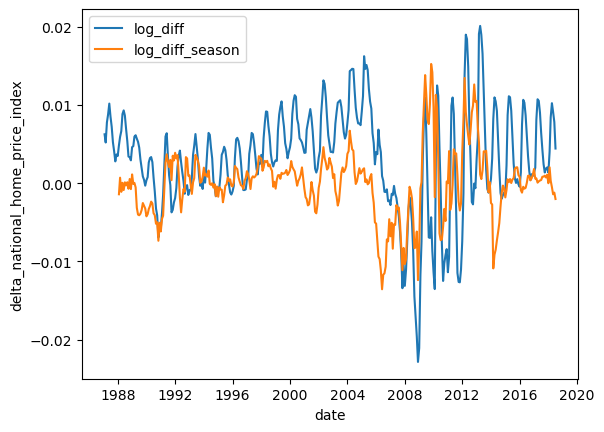

In [5]:
### seasonality 
nd["nonseason_nhpi"] = nd["delta_national_home_price_index"].diff(12)
sns.lineplot(x = "date", y = "delta_national_home_price_index" ,data = nd, label = "log_diff")
sns.lineplot(x = "date", y = nd.nonseason_nhpi, data = nd, label = "log_diff_season")
plt.show()

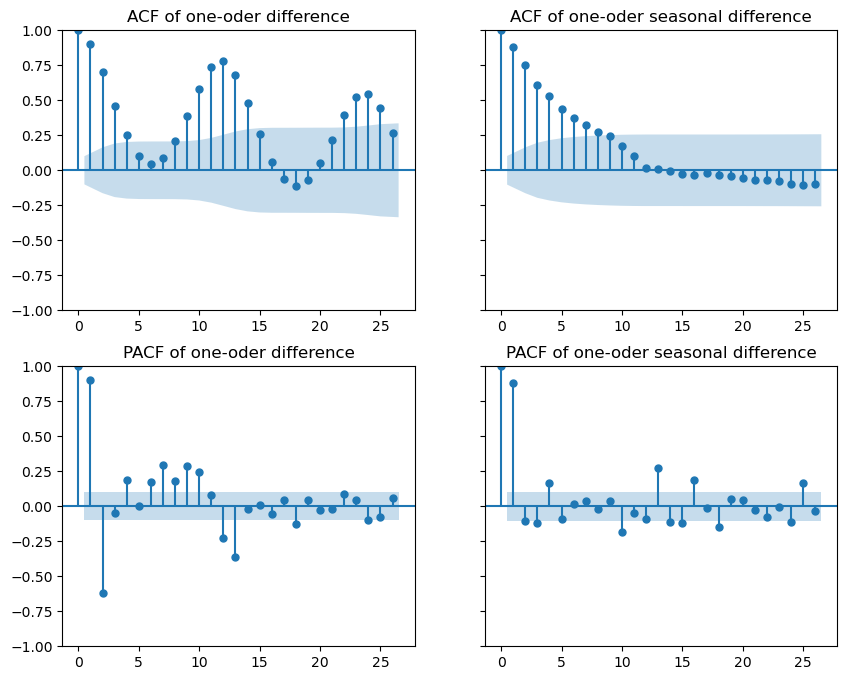

In [6]:
## plot the ACF and PACF
fig, axs = plt.subplots(2, 2, sharey= True, figsize = (10,8))
d = nd["delta_national_home_price_index"].dropna()
plot_acf(d, ax = axs[0,0], title = "ACF of one-oder difference")
plot_acf(nd.nonseason_nhpi.dropna(), ax = axs[0,1], title = "ACF of one-oder seasonal difference")
plot_pacf(d, ax = axs[1,0], title = "PACF of one-oder difference", method = "ywm")
plot_pacf(nd.nonseason_nhpi.dropna(), ax = axs[1,1], title = "PACF of one-oder seasonal difference", method = "ywm")
plt.show()

Indicates a $ ARIMA(2-4,1,0) \times (1,1,0)_{12}$ model from the ACF and PACF figure 

### Model recognition and model fit

In [7]:
### AIC / BIC rule to recognize model order (hyperparam)
params_list = list(product(range(1,5),[1], range(0,2), range(0,2),[0,1], range(0,2))) 
            #p,d,q,P,D,Q

def find_best_params(data, params_list):
    result = []
    for param in params_list:
        model = sarimax.SARIMAX(data, order = (param[0], param[1], param[2]),
                               seasonal_order= (param[3], param[4], param[5], 12)).fit()
        bicc = model.bic
        aicc = model.aic
        param_str = 'SARIMA({0},{1},{2})x({3},{4},{5},12)'.format(param[0], param[1], param[2], param[3],param[4],param[5])
        result.append({"parameter":param_str, "bic":bicc, "aic": aicc})
    return result

res_tab = find_best_params(nd.log_national_home_price_index.dropna(), params_list)
res_tab = pd.DataFrame(res_tab).sort_values(by = "bic").reset_index(drop = True)
res_tab.head(10)

,parameter,bic,aic
0,"SARIMA(4,1,0)x(1,0,1,12)",-3666.721754,-3694.247471
1,"SARIMA(2,1,1)x(1,0,1,12)",-3653.785085,-3677.378556
2,"SARIMA(1,1,1)x(1,0,1,12)",-3651.616195,-3671.277421
3,"SARIMA(2,1,0)x(1,0,1,12)",-3645.694265,-3665.355491
4,"SARIMA(3,1,1)x(1,0,1,12)",-3638.932719,-3666.458435
5,"SARIMA(3,1,0)x(1,0,1,12)",-3637.456190,-3661.049661
6,"SARIMA(1,1,0)x(1,0,0,12)",-3618.328400,-3630.125136
7,"SARIMA(2,1,1)x(1,0,0,12)",-3617.857425,-3637.518651
8,"SARIMA(4,1,1)x(1,0,0,12)",-3616.170362,-3643.696078
9,"SARIMA(3,1,1)x(1,0,0,12)",-3602.123148,-3625.716619


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:        log_national_home_price_index   No. Observations:                  378
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 12)   Log Likelihood                1854.124
Date:                              Thu, 26 Oct 2023   AIC                          -3694.247
Time:                                      14:23:19   BIC                          -3666.722
Sample:                                           0   HQIC                         -3683.322
                                              - 378                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2052      0.040     30.213      0.000       1.127       1.283
ar.L2         -0.2083      0.056     -3.706      0.000      -0.318      -0.098
ar.L3         -0.2863      0.038     -7.464      0.000      -0.362      -0.211
ar.L4          0.1950      0.031      6.297      0.000       0.134       0.256
ar.S.L12       0.8047      0.043     18.864      0.000       0.721       0.888
ma.S.L12      -0.3828      0.074     -5.187      0.000      -0.528      -0.238
sigma2      3.048e-06   1.05e-07     29.006      0.000    2.84e-06    3.25e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):              5674.91
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               6.18   Skew:                             1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

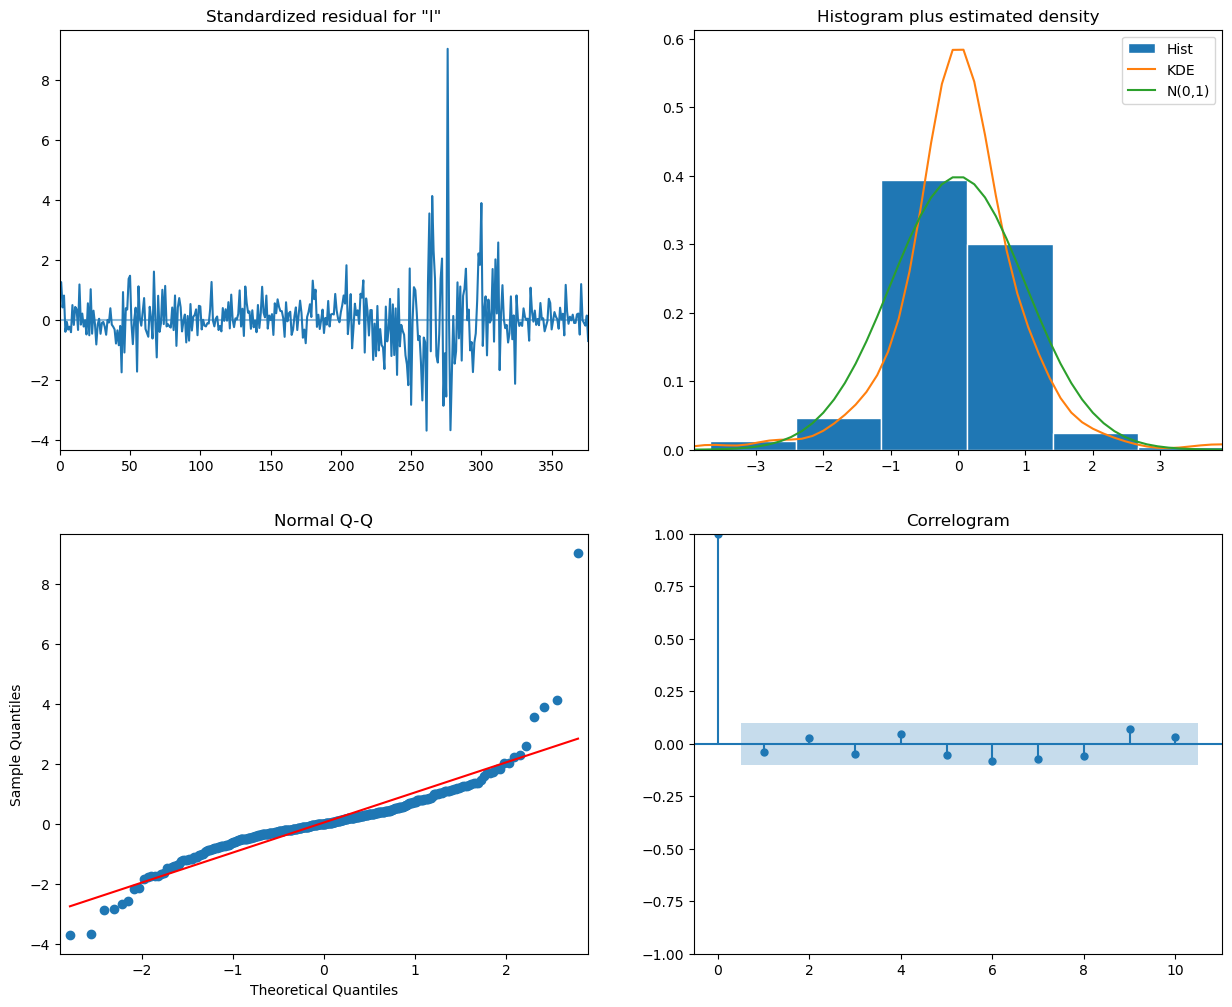

In [8]:
### fitting the model
mymodel = sarimax.SARIMAX(nd.log_national_home_price_index.dropna(), order = (4,1,0),
                         seasonal_order=(1,0,1,12)).fit()
resid = mymodel.resid
fig = mymodel.plot_diagnostics(figsize = (15,12))
mymodel.summary()

The residuals is not self-correlated but shows heteroscedasticity. And the distribution of the residuals is not normal like, it shows higher peak and thicker tail, more typically t-distribution like, like many of the financial data.

In [161]:
## autocorrelation test of the residuals --> do not reject the null
acorr_ljungbox(resid, lags = 15)

,lb_stat,lb_pvalue
1,0.000567,0.980999
2,0.000735,0.999633
3,0.000747,0.999995
4,0.000804,1.000000
5,0.000830,1.000000
6,0.000833,1.000000
7,0.000855,1.000000
8,0.000869,1.000000
9,0.000901,1.000000
10,0.000911,1.000000


<Figure size 400x300 with 0 Axes>

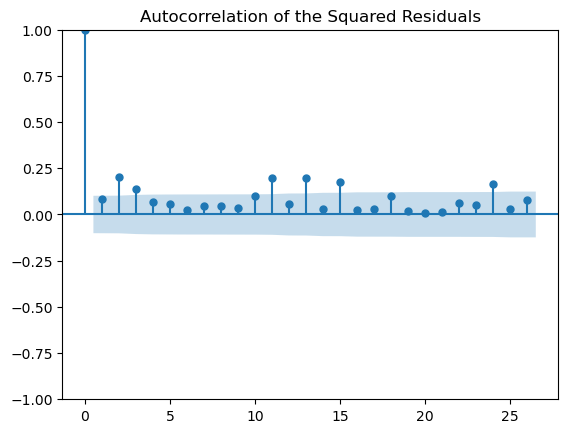

In [162]:
plt.figure(figsize = (4,3))
plot_acf(np.power(mymodel.resid[3:],2), title = "Autocorrelation of the Squared Residuals", alpha = 0.05)
plt.show()

In [163]:
### detect the ARCH effect
acorr_ljungbox(np.power(resid[1:],2), lags = 12)

,lb_stat,lb_pvalue
1,2.788196,0.094961
2,17.890777,0.000130
3,24.868924,0.000016
4,26.609258,0.000024
5,27.834637,0.000039
6,27.997561,0.000094
7,28.825243,0.000156
8,29.550302,0.000254
9,29.963486,0.000445
10,33.648727,0.000212


The residuals show ARCH effect, should effect the error estimation and confidence interval prediction. 

## Predict the future

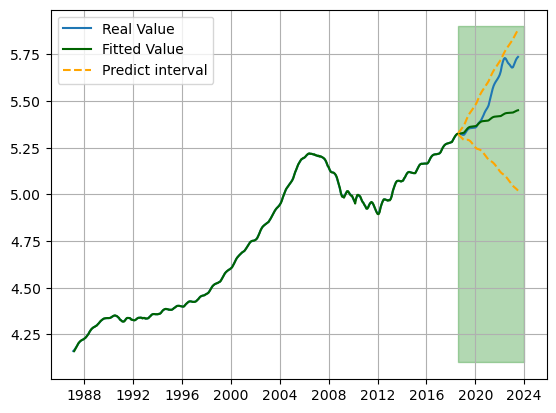

In [9]:
## No- rolling prediction 
pred_start = pd.to_datetime("2018-08-01")
pred_end = pd.to_datetime("2024-01-01")
pred = mymodel.get_prediction(start = 1, end = 437,dynamic = False)
x = data.date
x2 = (data.date >= pred_start) & (data.date <= pred_end)
true = data.log_national_home_price_index
fitted = pred.predicted_mean
pred_ci = pred.conf_int()
summary = pd.concat([x,true,fitted, pred_ci], axis = 1)
real_line, = plt.plot(x, summary.log_national_home_price_index, label = "Real Value")
plt.grid(True)
pred_line, = plt.plot(x, summary.predicted_mean, color = "darkgreen", label = "Fitted Value")
plt.fill_betweenx(np.arange(4.1,5.9,0.01),pred_start, pred_end, color = "green", alpha = 0.3)
upper_line, = plt.plot(x[x2], summary["upper log_national_home_price_index"][x2], color = "orange", linestyle = "--")
lower_line, = plt.plot(x[x2], summary["lower log_national_home_price_index"][x2], color = "orange", linestyle = "--", label = "Predict interval")
plt.legend()
plt.savefig("predict futures - arima.png")
plt.show()

In [10]:
## save the prediction
fitted_prev = fitted.rename("prev_predicted_mean")

### 1-Month Look-ahead Model Evaluation

In [11]:
start_date = '2018-07-01'
rolling_data = data.copy()
rolling_date = rolling_data[rolling_data["date"] >= pd.to_datetime(start_date)].index
results = list()

for i in range(1, len(rolling_date)):
    mymodel = sarimax.SARIMAX(rolling_data[:rolling_date[i]]['log_national_home_price_index'], order = (4,1,0),
                         seasonal_order=(1,0,1,12)).fit()   ## predict use right before i, and predict i 
    offset = rolling_date[i]
    pred = mymodel.get_prediction(start = 1, end = offset,dynamic = False)
    fitted = pred.predicted_mean
    pred_ci = pred.conf_int()
    results.append([rolling_data.loc[rolling_date[i], "date"],rolling_data.loc[rolling_date[i], 'log_national_home_price_index'], 
                    fitted.iloc[-1], pred_ci.iloc[-1, 0], pred_ci.iloc[-1, 1]])

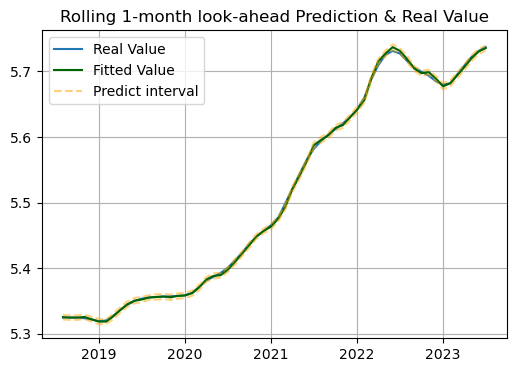

In [12]:
result_df = pd.DataFrame(results)
result_df.columns = ['date', 'true', 'fitted', 'lower', 'upper']

plt.figure(figsize = (6,4))
real_line, = plt.plot(result_df['date'], result_df['true'], label = "Real Value")
plt.grid(True)
pred_line, = plt.plot(result_df['date'], result_df['fitted'], color = "darkgreen", label = "Fitted Value")
upper_line, = plt.plot(result_df['date'], result_df['upper'], color = "orange", linestyle = "--", alpha = 0.5)
lower_line, = plt.plot(result_df['date'], result_df['lower'], color = "orange", linestyle = "--",alpha = 0.5, label = "Predict interval")
plt.title("Rolling 1-month look-ahead Prediction & Real Value")
plt.legend()
plt.savefig("Rooling 1-month look-ahead sarima.png")
plt.show()

In [13]:
mse = np.square(result_df['fitted'] - result_df['true']).mean()
rmse = np.sqrt(mse)
mae = np.abs((result_df['true'] - result_df['fitted'])).mean()

## if using linear trend to predict 
mean_diff = nd["delta_avg_house_prices"].mean()
base_rmse = np.sqrt(np.power((result_df['true']).diff() - mean_diff,2).mean())
base_mae = np.abs((result_df['true']).diff() - mean_diff).mean()

## result
res_dic = {"model":"SARIMA - 1 month ahead", "RMSE":rmse, "MAE":mae, "BASE_RMSE":base_rmse, "BASE_MAE":base_mae, "Improve Ratio": 1-rmse / base_rmse}
result_evaluation = pd.DataFrame([res_dic])
result_evaluation

,model,RMSE,MAE,BASE_RMSE,BASE_MAE,Improve Ratio
0,SARIMA - 1 month ahead,0.002405,0.001822,0.009347,0.007617,0.742702


### 6-month look-ahead

In [14]:
num_of_months = 6
start_date = '2018-01-01' # 6-month before "2018-07-01"
rolling_data = data.copy()
rolling_date = rolling_data[rolling_data["date"] >= pd.to_datetime(start_date)].index
results = list()

for i in range(1, len(rolling_date)-num_of_months+1):
    mymodel = sarimax.SARIMAX(rolling_data[:rolling_date[i]]['log_national_home_price_index'], order = (4,1,0),
                         seasonal_order=(1,0,1,12)).fit()   ## predict use right before i, and predict i 
    offset = rolling_date[i]+num_of_months-1
    pred = mymodel.get_prediction(start = 1, end = offset,dynamic = False)
    fitted = pred.predicted_mean
    pred_ci = pred.conf_int()
    results.append([rolling_data.loc[rolling_date[i+num_of_months-1], "date"],
                    rolling_data.loc[rolling_date[i+num_of_months-1], 'log_national_home_price_index'], 
                    fitted.iloc[-1], pred_ci.iloc[-1, 0], pred_ci.iloc[-1, 1]])

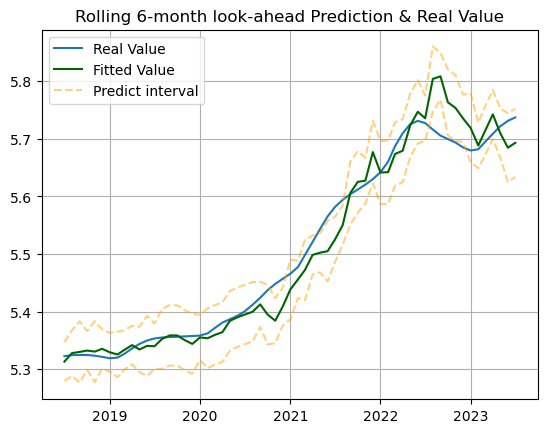

In [17]:
result_df = pd.DataFrame(results)
result_df.columns = ['date', 'true', 'fitted', 'lower', 'upper']
real_line, = plt.plot(result_df['date'], result_df['true'], label = "Real Value")
plt.grid(True)
pred_line, = plt.plot(result_df['date'], result_df['fitted'], color = "darkgreen", label = "Fitted Value")
#plt.fill_betweenx(np.arange(4.1,5.9,0.01),pred_start, pred_end, color = "green", alpha = 0.3)
upper_line, = plt.plot(result_df['date'], result_df['upper'], color = "orange", linestyle = "--", alpha = 0.5)
lower_line, = plt.plot(result_df['date'], result_df['lower'], color = "orange", linestyle = "--", label = "Predict interval", alpha = 0.5)
plt.title("Rolling 6-month look-ahead Prediction & Real Value")
plt.legend()
plt.savefig("Rooling 6-month look-ahead sarima.png")
plt.show()

In [18]:
mse = np.square(result_df['fitted'] - result_df['true']).mean()
rmse = np.sqrt(mse)
mae = np.abs((result_df['true'] - result_df['fitted'])).mean()

## if using linear trend to predict 
mean_diff = nd["log_avg_house_prices"].diff(6).mean()
base_rmse = np.sqrt(np.power((result_df['true']).diff(6) - mean_diff,2).mean())
base_mae = np.abs((result_df['true']).diff(6) - mean_diff).mean()

## result
res_dic2 = {"model":"SARIMA - 6 month ahead", "RMSE":rmse, "MAE":mae, "BASE_RMSE":base_rmse, "BASE_MAE":base_mae, "Improve Ratio": 1-rmse / base_rmse}
result_evaluation2 = pd.concat([result_evaluation, pd.DataFrame([res_dic2])], axis = 0)
result_evaluation2

,model,RMSE,MAE,BASE_RMSE,BASE_MAE,Improve Ratio
0,SARIMA - 1 month ahead,0.002405,0.001822,0.009347,0.007617,0.742702
0,SARIMA - 6 month ahead,0.032176,0.022762,0.047943,0.038909,0.328864


## Ⅱ Explore Possibility of Machine Learning

Use Machine Learning or regression should treat the values as uncorrelated and calculate more variables to represent the historical information about the time series. But since the number of samples is limited, machine learning has a significant problem of overfitting and do not compesate for the loss of time series information.

I start with discussing about the regression model, selecting some variables that shows stronger correlation in descriptive analysis.

#### Feature Engineering

In [21]:
## get some time series statistical indicators to summarize history information
## copy the datasets
total_data = init_data.copy()
PCA_data = pd.read_csv("../data/PCA_data.csv")[["PC1","PC2", "PC3","delta_PC1","delta_PC2", "delta_PC3"]]
total_data  = pd.concat([total_data, PCA_data], axis = 1)

## delayed change rate 
total_data["d1_delta_national_home_price_index"] = total_data["delta_national_home_price_index"].shift(1)
total_data["d2_delta_national_home_price_index"] = total_data["delta_national_home_price_index"].shift(2)
total_data["d11_delta_national_home_price_index"] = total_data["delta_national_home_price_index"].shift(11)

## longer change rate
total_data["delta6_national_home_price_index"] = total_data["log_national_home_price_index"].diff(6)
total_data["delta12_national_home_price_index"] = total_data["log_national_home_price_index"].diff(12)

## the ts quantile of current prices
total_data["rolling12_quantile_national_home_price_index"] = total_data["log_national_home_price_index"].rolling(12).rank()/12
total_data["rolling24_quantile_national_home_price_index"] = total_data["log_national_home_price_index"].rolling(24).rank()/24
total_data["rolling60_quantile_national_home_price_index"] = total_data["log_national_home_price_index"].rolling(60).rank()/60

## the ts z-score of current prices 
total_data["rolling12_quantile_national_home_price_index"] = (total_data["log_national_home_price_index"]
     - total_data["log_national_home_price_index"].rolling(12).mean())/ total_data["log_national_home_price_index"].rolling(12).std()
total_data["rolling24_quantile_national_home_price_index"] = (total_data["log_national_home_price_index"]
     - total_data["log_national_home_price_index"].rolling(24).mean())/ total_data["log_national_home_price_index"].rolling(24).std()
total_data["rolling60_quantile_national_home_price_index"] = (total_data["log_national_home_price_index"]
     - total_data["log_national_home_price_index"].rolling(60).mean())/ total_data["log_national_home_price_index"].rolling(60).std()

## the volatility of ts delta prices
total_data["volat12_delta_national_home_price_index"] = total_data["delta_national_home_price_index"].rolling(12).std()
total_data["volat24_delta_national_home_price_index"] = total_data["delta_national_home_price_index"].rolling(24).std()

## the range of high-low 
total_data["range12_delta_national_home_price_index"] = total_data["log_national_home_price_index"].rolling(12).max() -\
                                                                    total_data["log_national_home_price_index"].rolling(12).min()
total_data["range24_delta_national_home_price_index"] = total_data["log_national_home_price_index"].rolling(24).max() -\
                                                                    total_data["log_national_home_price_index"].rolling(24).min()

## 【TO PREDICT the forward 1-month log change rate】
total_data["f1_delta_national_home_price_index"] = total_data["delta_national_home_price_index"].shift(-1)
total_data = total_data[~total_data["f1_delta_national_home_price_index"].isna()]

## FILL NA with means
cols = total_data.columns
total_data.fillna(total_data.mean(), inplace = True)

### SPLIT the test and train data
total_data.drop(["log_national_home_price_index"], axis = 1, inplace=True)
total_data = total_data.set_index("date")

data_X = total_data.drop(["f1_delta_national_home_price_index"], axis = 1)
data_Y = total_data[["f1_delta_national_home_price_index"]]

test_X = data_X[total_data.index >= pd.to_datetime("2018-08-01")].copy()
test_Y = data_Y[total_data.index >= pd.to_datetime("2018-08-01")].copy()

train_X = data_X[total_data.index < pd.to_datetime("2018-08-01")].copy()
train_Y = data_Y[total_data.index < pd.to_datetime("2018-08-01")].copy()

train_X

,delta_national_home_price_index,capacity_util,real_interest_rate,fed_fund_rate,stickyCPI,housing_started,housing_completed,personal_saving_rate,unemploy_rate,GDP_incre_lastQuarter,...,d11_delta_national_home_price_index,delta6_national_home_price_index,delta12_national_home_price_index,rolling12_quantile_national_home_price_index,rolling24_quantile_national_home_price_index,rolling60_quantile_national_home_price_index,volat12_delta_national_home_price_index,volat24_delta_national_home_price_index,range12_delta_national_home_price_index,range24_delta_national_home_price_index
date,,,,,,,,,,,,,,,,,,,,,
1987-01-01,0.003607,78.9277,3.604566,6.43,0.36624,1774.0,1862.0,9.4,6.6,0.010784,...,0.003691,0.021264,0.042548,0.911101,1.008141,1.284724,0.004456,0.004735,0.059754,0.118392
1987-02-01,0.006256,79.8385,3.578581,6.10,0.32033,1784.0,1771.0,8.2,6.6,0.010784,...,0.003691,0.021264,0.042548,0.911101,1.008141,1.284724,0.004456,0.004735,0.059754,0.118392
1987-03-01,0.005210,79.8055,3.554785,6.13,0.33113,1726.0,1694.0,8.1,6.6,0.010784,...,0.003691,0.021264,0.042548,0.911101,1.008141,1.284724,0.004456,0.004735,0.059754,0.118392
1987-04-01,0.007772,80.1758,3.760199,6.37,0.50201,1614.0,1735.0,4.1,6.3,0.013759,...,0.003691,0.021264,0.042548,0.911101,1.008141,1.284724,0.004456,0.004735,0.059754,0.118392
1987-05-01,0.008796,80.5155,4.359714,6.85,0.30051,1628.0,1713.0,7.8,6.3,0.013759,...,0.003691,0.021264,0.042548,0.911101,1.008141,1.284724,0.004456,0.004735,0.059754,0.118392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-01,0.008435,78.9760,1.029536,1.51,0.21385,1318.0,1181.0,5.9,4.0,0.017342,...,0.010739,0.019086,0.062569,1.507798,1.566719,1.723434,0.003647,0.003730,0.051830,0.106600
2018-04-01,0.010236,79.8677,1.014354,1.69,0.20850,1276.0,1224.0,6.0,4.0,0.014441,...,0.010536,0.027952,0.062066,1.953806,1.731398,1.808988,0.003580,0.003702,0.051530,0.106536
2018-05-01,0.009120,79.1543,1.216092,1.70,0.18207,1357.0,1262.0,6.0,3.8,0.014441,...,0.009028,0.035187,0.060650,2.074994,1.821098,1.866990,0.003406,0.003634,0.051622,0.106977


## Regression Model

Need some assumptions:
* Variables X are strictly exogenous. $E(\epsilon_t | X_t) = 0$.  
* We can get the $X_t$ at the time we want to predict $Y_t$ because the home price index is usually released later than the other indicators.(GDP indicators has already be delayed)

#### Model fitting

In [27]:
### Select variables from descriptive analysis
variables = ["delta_PC2","delta_PC3","d1_delta_national_home_price_index",
             "delta_national_home_price_index",
            "d11_delta_national_home_price_index"]

In [23]:
### Fitting the linear models
X = train_X[variables]
y = train_Y["f1_delta_national_home_price_index"]
X = sm.add_constant(X)
linearmodel = sm.OLS(y,X).fit()
linearmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     f1_delta_national_home_price_index   R-squared:                       0.898
Model:                                            OLS   Adj. R-squared:                  0.896
Method:                                 Least Squares   F-statistic:                     654.5
Date:                                Thu, 26 Oct 2023   Prob (F-statistic):          3.74e-182
Time:                                        14:45:16   Log-Likelihood:                 1801.8
No. Observations:                                 379   AIC:                            -3592.
Df Residuals:                                     373   BIC:                            -3568.
Df Model:                                           5                                         
Covariance Type:                            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.0004      0.000      2.934      0.004       0.000       0.001
delta_PC2                              -0.0010      0.000     -2.104      0.036      -0.002   -6.74e-05
delta_PC3                              -0.0007      0.000     -2.671      0.008      -0.001      -0.000
d1_delta_national_home_price_index     -0.5581      0.040    -13.956      0.000      -0.637      -0.479
delta_national_home_price_index         1.2816      0.048     26.591      0.000       1.187       1.376
d11_delta_national_home_price_index     0.1594      0.026      6.174      0.000       0.109       0.210
==============================================================================
Omnibus:                      177.628   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2097.894
Skew:                           1.654   Prob(JB):                         0.00
Kurtosis:                      14.041   Cond. No.                         573.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
### predict the change rate
pred_X = sm.add_constant(test_X[variables])
real_y = test_Y["f1_delta_national_home_price_index"]
pred = linearmodel.predict(pred_X)

mse = np.square(real_y - pred).mean()
rmse = np.sqrt(mse)
mae = np.abs((real_y - pred)).mean()

## if using linear trend to predict 
mean_diff = nd["log_avg_house_prices"].diff(1).mean()
base_rmse = np.sqrt(np.power((real_y) - mean_diff,2).mean())
base_mae = np.abs((real_y) - mean_diff).mean()

## result
res_dic3 = {"model":"Regression - PCA", "RMSE":rmse, "MAE":mae, "BASE_RMSE":base_rmse, "BASE_MAE":base_mae, "Improve Ratio": 1-rmse / base_rmse}
result_evaluation3 = pd.concat([result_evaluation2, pd.DataFrame([res_dic3])], axis = 0)
result_evaluation3

,model,RMSE,MAE,BASE_RMSE,BASE_MAE,Improve Ratio
0,SARIMA - 1 month ahead,0.002405,0.001822,0.009347,0.007617,0.742702
0,SARIMA - 6 month ahead,0.032176,0.022762,0.047943,0.038909,0.328864
0,Regression - PCA,0.003065,0.002187,0.009307,0.007585,0.670675


In [35]:
select = ["housing_started","real_interest_rate","personal_saving_rate","unemploy_rate","delta_logPCE",
         "d1_delta_national_home_price_index",
             "delta_national_home_price_index",
            "d11_delta_national_home_price_index"]

### Fitting the linear models
X = train_X[select]
y = train_Y["f1_delta_national_home_price_index"]
X = sm.add_constant(X)
linearmodel = sm.OLS(y,X).fit()
linearmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     f1_delta_national_home_price_index   R-squared:                       0.908
Model:                                            OLS   Adj. R-squared:                  0.906
Method:                                 Least Squares   F-statistic:                     458.8
Date:                                Thu, 26 Oct 2023   Prob (F-statistic):          6.82e-187
Time:                                        14:51:28   Log-Likelihood:                 1822.8
No. Observations:                                 379   AIC:                            -3628.
Df Residuals:                                     370   BIC:                            -3592.
Df Model:                                           8                                         
Covariance Type:                            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  -0.0057      0.001     -5.283      0.000      -0.008      -0.004
housing_started                      2.759e-06   4.53e-07      6.090      0.000    1.87e-06    3.65e-06
real_interest_rate                     -0.0006      0.000     -5.460      0.000      -0.001      -0.000
personal_saving_rate                    0.0004   7.98e-05      5.230      0.000       0.000       0.001
unemploy_rate                           0.0002      0.000      1.996      0.047     3.1e-06       0.000
delta_logPCE                            0.0485      0.024      1.979      0.049       0.000       0.097
d1_delta_national_home_price_index     -0.5585      0.040    -13.995      0.000      -0.637      -0.480
delta_national_home_price_index         1.2139      0.049     24.743      0.000       1.117       1.310
d11_delta_national_home_price_index     0.1817      0.029      6.362      0.000       0.126       0.238
==============================================================================
Omnibus:                      208.273   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3013.726
Skew:                           1.974   Prob(JB):                         0.00
Kurtosis:                      16.239   Cond. No.                     8.54e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
### Fitting the linear models
X = train_X[select]
y = train_Y["f1_delta_national_home_price_index"]
X = sm.add_constant(X)
linearmodel = sm.OLS(y,X).fit()
linearmodel.summary()

### predict the change rate
pred_X = sm.add_constant(test_X[select])
real_y = test_Y["f1_delta_national_home_price_index"]
pred = linearmodel.predict(pred_X)

mse = np.square(real_y - pred).mean()
rmse = np.sqrt(mse)
mae = np.abs((real_y - pred)).mean()

## if using linear trend to predict 
mean_diff = nd["log_avg_house_prices"].diff(1).mean()
base_rmse = np.sqrt(np.power((real_y) - mean_diff,2).mean())
base_mae = np.abs((real_y) - mean_diff).mean()

## result
res_dic4 = {"model":"Regression - Selected variables", "RMSE":rmse, "MAE":mae, "BASE_RMSE":base_rmse, "BASE_MAE":base_mae, "Improve Ratio": 1-rmse / base_rmse}
result_evaluation4 = pd.concat([result_evaluation3, pd.DataFrame([res_dic4])], axis = 0)
result_evaluation4

,model,RMSE,MAE,BASE_RMSE,BASE_MAE,Improve Ratio
0,SARIMA - 1 month ahead,0.002405,0.001822,0.009347,0.007617,0.742702
0,SARIMA - 6 month ahead,0.032176,0.022762,0.047943,0.038909,0.328864
0,Regression - PCA,0.003065,0.002187,0.009307,0.007585,0.670675
0,Regression - Selected variables,0.003716,0.002755,0.009307,0.007585,0.600793


## Machine Learning Models

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

In [125]:
## Preprocessing of the X - dataset
stdsclr1= StandardScaler() 
stdsclr2= StandardScaler() 

variables = ["delta_PC2","delta_PC3","d1_delta_national_home_price_index", "delta_national_home_price_index",
            "d11_delta_national_home_price_index"]
selected_train_X = stdsclr1.fit_transform(train_X[variables])
selected_test_X = stdsclr1.transform(test_X[variables])

nonselcted_train_X = stdsclr2.fit_transform(train_X[variables])
nonselected_test_X = stdsclr2.transform(test_X[variables])

train_Y = np.array(train_Y).reshape(-1)
test_Y = np.array(test_Y).reshape(-1)

In [127]:
## RandomForest 
clf = RandomForestRegressor(max_depth=8, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf = clf.fit(selected_train_X, train_Y)
y_pred = rf.predict(selected_test_X)
y_fit = rf.predict(selected_train_X)
print(np.mean(np.abs(y_pred - test_Y)), np.mean(np.abs(y_fit-train_Y))) #overfit

0.0029713420493529532 0.0008870582651642268


In [128]:
## Decision Tree
clf = DecisionTreeRegressor(max_depth=8)
rf = clf.fit(selected_train_X, train_Y)
y_pred = rf.predict(selected_test_X)
y_fit = rf.predict(selected_train_X)
print(np.mean(np.abs(y_pred - test_Y)), np.mean(np.abs(y_fit-train_Y))) #overfit

0.0036127353917132597 0.000635380162135315


In [129]:
## AdabAdaBoostRegressor 
clf = AdaBoostRegressor(learning_rate=0.001)
rf = clf.fit(selected_train_X, train_Y)
y_pred = rf.predict(selected_test_X)
y_fit = rf.predict(selected_train_X)
print(np.mean(np.abs(y_pred - test_Y)), np.mean(np.abs(y_fit-train_Y))) #overfit

0.0032764534537101046 0.00172321071264056


## Ⅲ Consider SARIMAX

Select exogenous variables. The logics of chosen variables:
* Shows significant correlation with the log-diff national home price index.
* The times series of the chosen variables is stationary. 
* Logically and theoretically influence the home price.

We choose [1. Personal saving rate(delay12), 2. mortgage change, 3.PCAs]

In [53]:
## prepare the data
data2 = pd.read_csv("../data/Analyze_data.csv")
PCA_data = pd.read_csv("../data/PCA_data.csv")
data2 = pd.merge(data2, PCA_data, how = "inner", on = "date")

data2["date"] = data2["date"].apply(lambda x: pd.to_datetime(x))
data2 = data2[["date","PC2","delta_PC1","delta_PC2","delta_PC3","personal_saving_rate","mortgage",
               "log_national_home_price_index","delta_national_home_price_index"]]
data2["delta_PC2_d6"] = data2["delta_PC2"].shift(6)
data2["personal_saving_rate_d6"] = data2["personal_saving_rate"].shift(6)
data2["mortgage_d6"] = data2["mortgage"].shift(6)

data2.dropna(inplace = True)
data2 = data2.reset_index(drop = True)
train = data2[data2["date"] < pd.to_datetime("2018-08-01")].copy()
test = data2[data2["date"] >= pd.to_datetime("2018-08-01")].copy()

In [54]:
## FIND the appropiate order of the model with plot figures
X = train[["personal_saving_rate_d6","delta_PC2_d6"]]#[["mortgage_d6"]]
X = sm.add_constant(X)
Y = train["delta_national_home_price_index"]

firststepLM = sm.OLS(Y,X).fit()
firststepLM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     delta_national_home_price_index   R-squared:                       0.010
Model:                                         OLS   Adj. R-squared:                  0.005
Method:                              Least Squares   F-statistic:                     1.939
Date:                             Thu, 26 Oct 2023   Prob (F-statistic):              0.145
Time:                                     15:07:08   Log-Likelihood:                 1367.7
No. Observations:                              378   AIC:                            -2729.
Df Residuals:                                  375   BIC:                            -2717.
Df Model:                                        2                                         
Covariance Type:                         nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0021      0.001      1.843      0.066      -0.000       0.004
personal_saving_rate_d6     0.0002      0.000      0.953      0.341      -0.000       0.001
delta_PC2_d6               -0.0022      0.001     -1.756      0.080      -0.005       0.000
==============================================================================
Omnibus:                       33.364   Durbin-Watson:                   0.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.002
Skew:                          -0.604   Prob(JB):                     1.39e-11
Kurtosis:                       4.310   Cond. No.                         24.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
## plot the ACF and PACF
#fig, axs = plt.subplots(2, 2, sharey= True, figsize = (10,9))
#regreResid = pd.Series(firststepLM.resid)
#plot_acf(regreResid, ax = axs[0,0], title = "ACF of the Residuals of the first-step regression")
#plot_acf(regreResid.diff(12).dropna(), ax = axs[0,1], title = "ACF of the Residuals of the first-step \nregression with seasonal difference")
#plot_pacf(regreResid, ax = axs[1,0], title = "PACF of the Residuals of the first-step regression", method = "ywm")
#plot_pacf(regreResid.diff(12).dropna(), ax = axs[1,1], title = "ACF of the Residuals of the first-step regression\n with seasonal difference", method = "ywm")
#plt.show()

The residual ACF/PACF pattern is similar to the time series itself.

In [58]:
### AIC / BIC rule to recognize model order (hyperparam)
X = train[["personal_saving_rate_d6"]]#[["mortgage_d6"]]
params_list = list(product(range(1,5),[1], range(0,2), range(0,2),[0,1], range(0,2))) 
            #p,d,q,P,D,Q

def find_best_params_x(data, params_list):
    result = []
    for param in params_list:
        model = sarimax.SARIMAX(data, order = (param[0], param[1], param[2]),
                               seasonal_order= (param[3], param[4], param[5], 12),
                                exog = X).fit()
        bicc = model.bic
        aicc = model.aic
        param_str = 'SARIMA({0},{1},{2})x({3},{4},{5},12)'.format(param[0], param[1], param[2], param[3],param[4],param[5])
        result.append({"parameter":param_str, "bic":bicc, "aic": aicc})
    return result

res_tab = find_best_params_x(train.log_national_home_price_index, params_list)
res_tab = pd.DataFrame(res_tab).sort_values(by = "bic").reset_index(drop = True)
res_tab.head(10)

,parameter,bic,aic
0,"SARIMA(4,1,1)x(1,0,1,12)",-3653.802943,-3689.193150
1,"SARIMA(4,1,0)x(1,0,1,12)",-3651.420622,-3682.878584
2,"SARIMA(4,1,0)x(1,0,0,12)",-3635.316771,-3662.842487
3,"SARIMA(1,1,0)x(1,0,0,12)",-3621.765548,-3637.494529
4,"SARIMA(1,1,1)x(1,0,0,12)",-3619.853939,-3639.515165
5,"SARIMA(4,1,1)x(1,0,0,12)",-3615.417085,-3646.875046
6,"SARIMA(1,1,0)x(1,0,1,12)",-3582.730213,-3602.391439
7,"SARIMA(2,1,0)x(0,0,1,12)",-3570.821788,-3590.483014
8,"SARIMA(2,1,1)x(0,0,1,12)",-3556.503957,-3580.097428
9,"SARIMA(2,1,0)x(1,0,0,12)",-3540.520116,-3560.181342


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:        log_national_home_price_index   No. Observations:                  378
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 12)   Log Likelihood                1849.439
Date:                              Thu, 26 Oct 2023   AIC                          -3682.879
Time:                                      15:07:55   BIC                          -3651.421
Sample:                                           0   HQIC                         -3670.392
                                              - 378                                         
Covariance Type:                                opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
personal_saving_rate_d6     0.0001   6.01e-05      1.724      0.085   -1.42e-05       0.000
ar.L1                       1.3048      0.044     29.680      0.000       1.219       1.391
ar.L2                      -0.1955      0.057     -3.429      0.001      -0.307      -0.084
ar.L3                      -0.4428      0.033    -13.226      0.000      -0.508      -0.377
ar.L4                       0.2226      0.032      6.870      0.000       0.159       0.286
ar.S.L12                    0.7945      0.047     16.794      0.000       0.702       0.887
ma.S.L12                   -0.4186      0.074     -5.647      0.000      -0.564      -0.273
sigma2                   3.144e-06   1.26e-07     24.937      0.000     2.9e-06    3.39e-06
===================================================================================
Ljung-Box (L1) (Q):                   2.96   Jarque-Bera (JB):              7028.88
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               6.05   Skew:                             1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

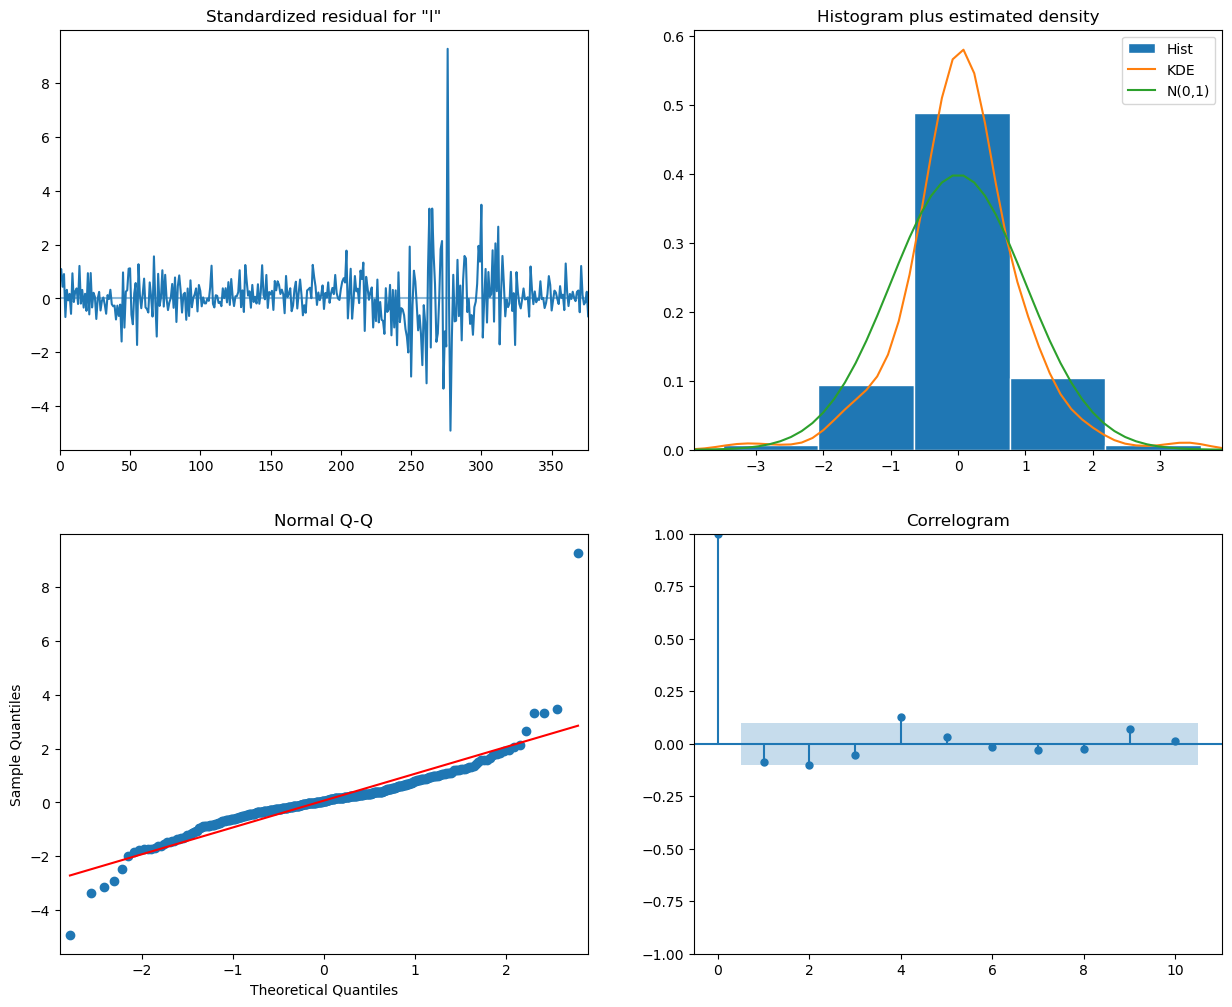

In [57]:
### fitting the model
X = train[["personal_saving_rate_d6"]]#[["mortgage_d6]]
mymodel_x = sarimax.SARIMAX(train.log_national_home_price_index, order = (4,1,0),exog = X,
                         seasonal_order=(1,0,1,12)).fit()
resid = mymodel_x.resid
fig = mymodel_x.plot_diagnostics(figsize = (15,12))
mymodel_x.summary()

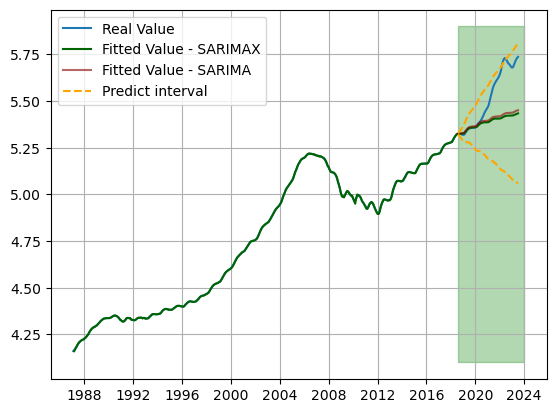

In [49]:
## No- rolling prediction 
pred_start = pd.to_datetime("2018-08-01")
pred_end = pd.to_datetime("2024-01-01")

exog = test[["personal_saving_rate_d6"]]#[["personal_saving_rate_d6"]]

pred = mymodel_x.get_prediction(start = 1, end = len(data)-1,dynamic = False, exog = exog)
x = data2.date
x2 = (data2.date >= pred_start) & (data2.date <= pred_end)
true = data2.log_national_home_price_index
fitted = pred.predicted_mean
pred_ci = pred.conf_int()

summary = pd.concat([x,true,fitted, pred_ci, fitted_prev], axis = 1)

real_line, = plt.plot(x, summary.log_national_home_price_index, label = "Real Value")
plt.grid(True)
pred_line, = plt.plot(x, summary.predicted_mean, color = "darkgreen", label = "Fitted Value - SARIMAX",alpha = 1)
prev_line, = plt.plot(x[x2], summary.prev_predicted_mean[x2], color = "darkred", label = "Fitted Value - SARIMA",alpha = 0.6)
plt.fill_betweenx(np.arange(4.1,5.9,0.01),pred_start, pred_end, color = "green", alpha = 0.3)
upper_line, = plt.plot(x[x2], summary["upper log_national_home_price_index"][x2], color = "orange", linestyle = "--")
lower_line, = plt.plot(x[x2], summary["lower log_national_home_price_index"][x2], color = "orange", linestyle = "--", label = "Predict interval")
plt.legend()
plt.show()

In [50]:
num_of_months = 6
start_date = '2018-01-01' # 6-month before "2018-07-01"
rolling_data = data2.copy()
rolling_date = rolling_data[rolling_data["date"] >= pd.to_datetime(start_date)].index
rolling_exog = rolling_data[["personal_saving_rate_d6"]]
results = list()

for i in range(1, len(rolling_date)-num_of_months+1):
    fit_exog = rolling_exog[:rolling_date[i]]
    pre_exog = rolling_exog[rolling_date[i]:rolling_date[i]+num_of_months]
    mymodel = sarimax.SARIMAX(rolling_data[:rolling_date[i]]['log_national_home_price_index'], order = (2,1,0),exog=fit_exog,
                         seasonal_order=(1,0,1,12)).fit()   ## predict use right before i, and predict i 
    offset = rolling_date[i]+num_of_months-1
    pred = mymodel.get_prediction(start = 1, end = offset,dynamic = False,exog=pre_exog)
    fitted = pred.predicted_mean
    pred_ci = pred.conf_int()
    results.append([rolling_data.loc[rolling_date[i+num_of_months-1], "date"],
                    rolling_data.loc[rolling_date[i+num_of_months-1], 'log_national_home_price_index'], 
                    fitted.iloc[-1], pred_ci.iloc[-1, 0], pred_ci.iloc[-1, 1]])

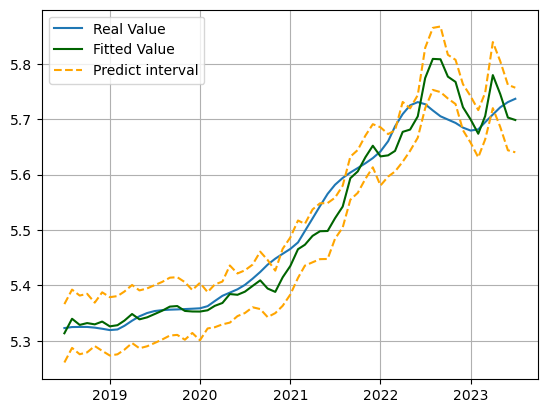

In [51]:
result_df = pd.DataFrame(results)
result_df.columns = ['date', 'true', 'fitted', 'lower', 'upper']
real_line, = plt.plot(result_df['date'], result_df['true'], label = "Real Value")
plt.grid(True)
pred_line, = plt.plot(result_df['date'], result_df['fitted'], color = "darkgreen", label = "Fitted Value")
#plt.fill_betweenx(np.arange(4.1,5.9,0.01),pred_start, pred_end, color = "green", alpha = 0.3)
upper_line, = plt.plot(result_df['date'], result_df['upper'], color = "orange", linestyle = "--")
lower_line, = plt.plot(result_df['date'], result_df['lower'], color = "orange", linestyle = "--", label = "Predict interval")
plt.legend()
plt.show()

In [52]:
mse = np.square(result_df['fitted'] - result_df['true']).mean()
rmse = np.sqrt(mse)
mae = np.abs((result_df['true'] - result_df['fitted'])).mean()

## if using linear trend to predict 
mean_diff = nd["log_avg_house_prices"].diff(6).mean()
base_rmse = np.sqrt(np.power((result_df['true']).diff(6) - mean_diff,2).mean())
base_mae = np.abs((result_df['true']).diff(6) - mean_diff).mean()

## result
res_dic = {"model":"SARIMAX - 6 month ahead", "RMSE":rmse, "MAE":mae, "BASE_RMSE":base_rmse, "BASE_MAE":base_mae, "Improve Ratio": 1-rmse / base_rmse}
result_evaluation5 = pd.concat([result_evaluation4, pd.DataFrame([res_dic])], axis = 0)
result_evaluation5

,model,RMSE,MAE,BASE_RMSE,BASE_MAE,Improve Ratio
0,SARIMA - 1 month ahead,0.002405,0.001822,0.009347,0.007617,0.742702
0,SARIMA - 6 month ahead,0.032176,0.022762,0.047943,0.038909,0.328864
0,Regression - PCA,0.003065,0.002187,0.009307,0.007585,0.670675
0,Regression - Selected variables,0.003716,0.002755,0.009307,0.007585,0.600793
0,SARIMAX - 6 month ahead,0.035054,0.025411,0.047943,0.038909,0.268845
